# Assignment 3

In this assignment, you will learn about regularization methods. You will also implement the ridge regularization method using gradient descent and stochastic gradient descent and test it on "Wine quality" data.

1. Use the "Communities and Crime" dataset you used in the previous assignment with the same preprocessing.
2. Fit models using ridge and lasso regression. Try different values of the regularization parameter and evaluate its effect. Choose the optimal regularization parameter.
3. Compare the results of the feature selection you implemented in the previous assignment with the attributes lasso selected.
4. Download the "Wine quality" dataset. Choose only the white wine data. Prepare your data for modeling
5. Implement ridge regression with: - gradient descent - stochastic gradient descent and test it on the "Wine quality" data.
6. Test different learning rates and try to find the optimal one.
7. Compare the time to convergence and the results of the two gradient descents you implemented.


In [1]:
# Import all dependencies
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib_venn import venn2, venn2_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Data Retrieval


In [2]:
# Download the data from https://archive.ics.uci.edu/dataset/183/communities+and+crime
# Load the data into a pandas dataframe, and remove the first 5 columns (state, county, community, communityname, fold)
with open("./data/communities.names") as file:
    columns = [
        line.split(" ")[1] for line in file.readlines() if line.startswith("@attribute")
    ]
communities_and_crime_data = pd.read_csv(
    "./data/communities.data", header=None, names=columns, na_values="?"
)


columns_to_remove = ["state", "county", "community", "communityname", "fold"]
communities_and_crime_data = communities_and_crime_data.drop(columns=columns_to_remove)
communities_and_crime_data

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [3]:
# Download the data from https://archive.ics.uci.edu/dataset/186/wine+quality
# Load the data into a pandas dataframe (use white wine only)
wine_quality_data = pd.read_csv("./data/winequality-white.csv", sep=";")
wine_quality_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


### Data Analyzing


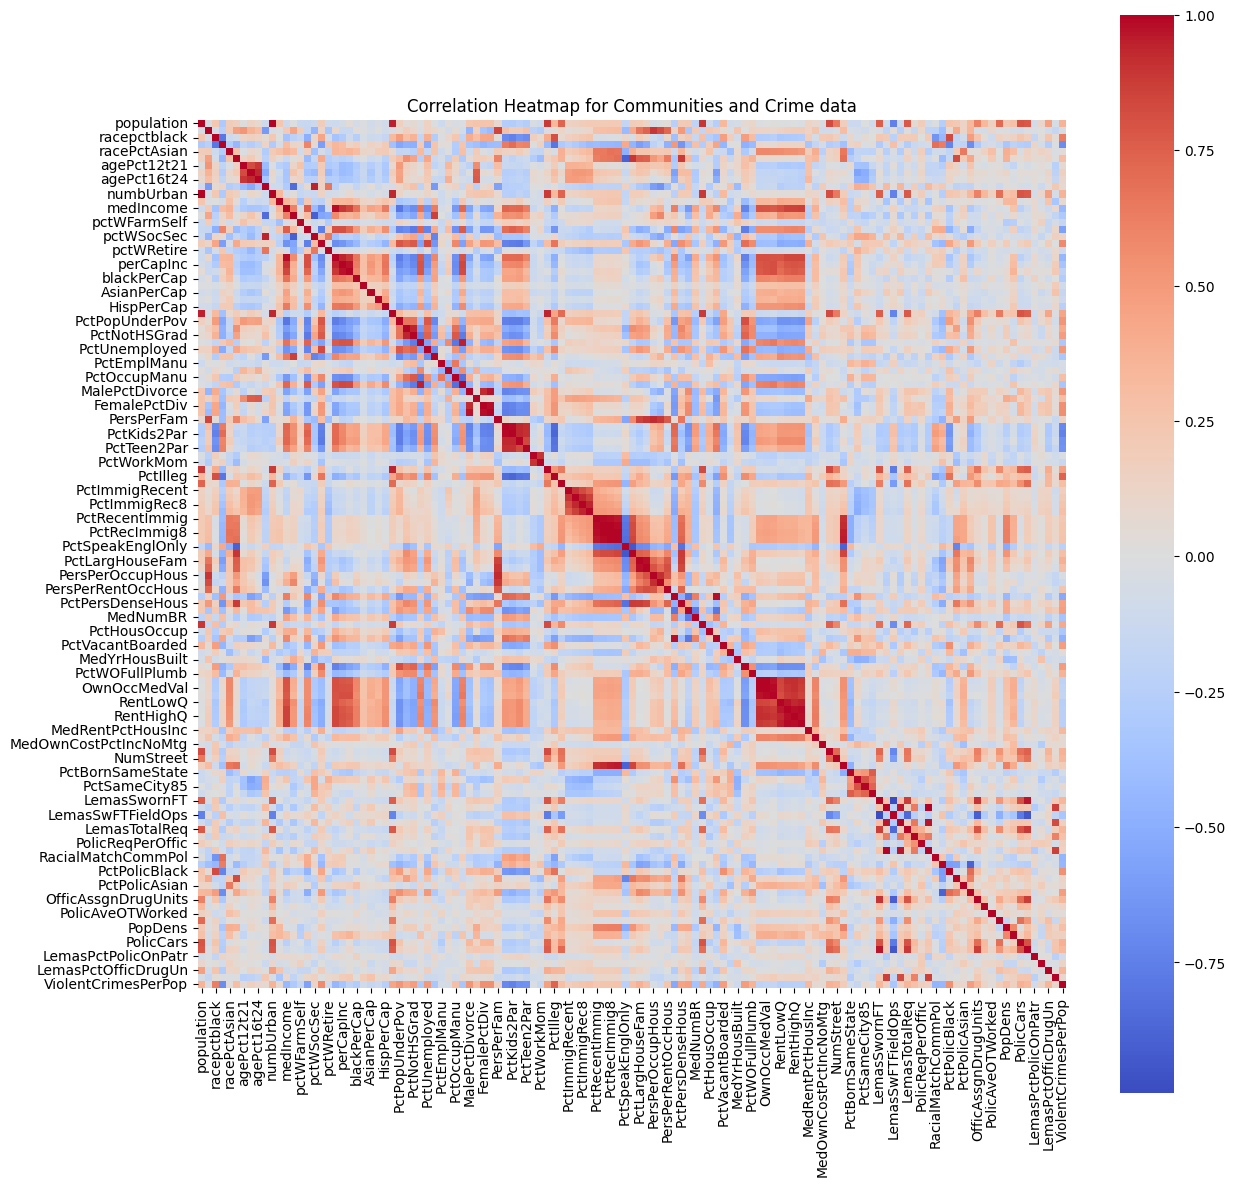

In [4]:
# Exploratory Data Analysis (EDA)
communities_and_crime_correlation_matrix = communities_and_crime_data.corr()

_, ax = plt.subplots(1, figsize=(14, 14))
sns.heatmap(
    communities_and_crime_correlation_matrix,
    square=True,
    cmap="coolwarm",
    ax=ax,
)
plt.title("Correlation Heatmap for Communities and Crime data")
plt.show()

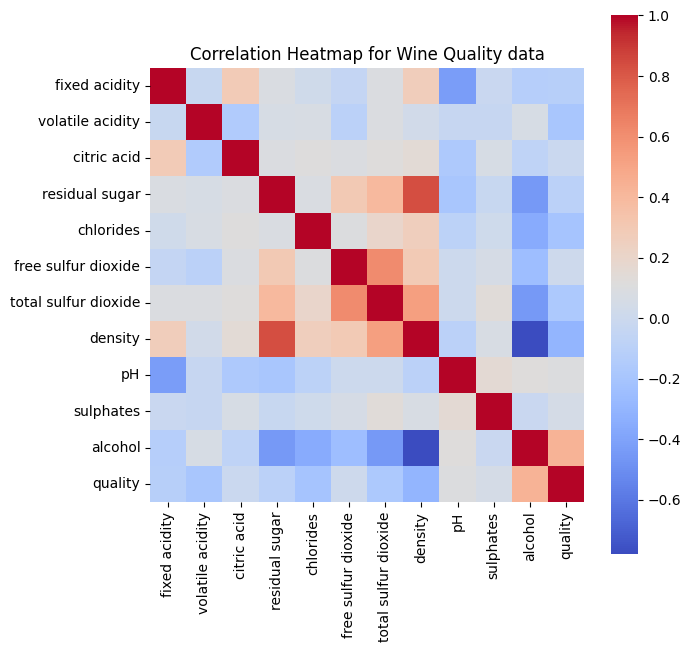

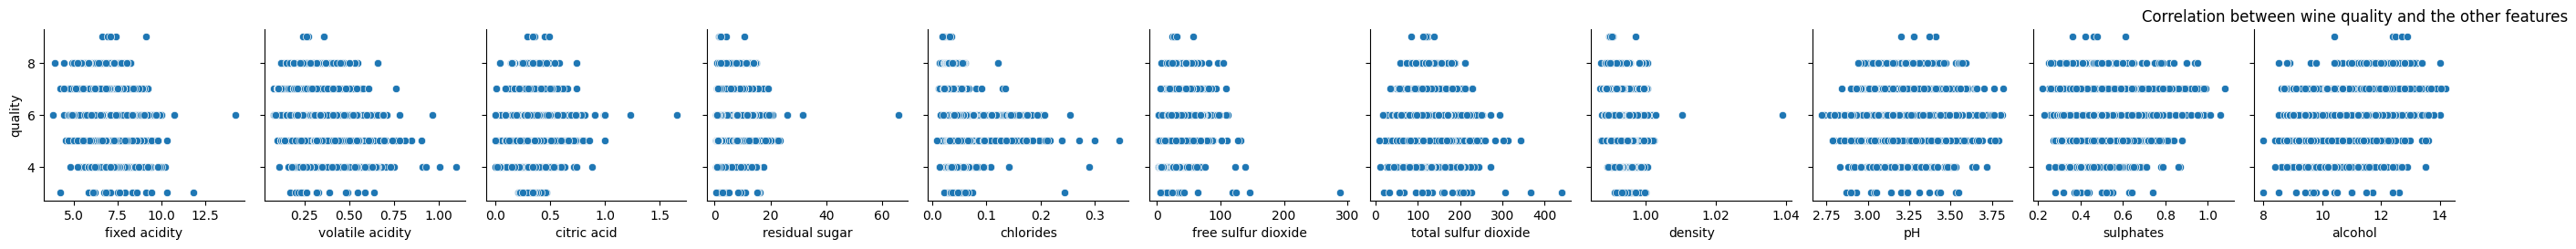

In [5]:
# Exploratory Data Analysis (EDA)
wine_quality_correlation_matrix = wine_quality_data.corr()

_, ax = plt.subplots(1, figsize=(7, 7))
sns.heatmap(
    wine_quality_correlation_matrix,
    square=True,
    cmap="coolwarm",
    ax=ax,
)
plt.title("Correlation Heatmap for Wine Quality data")
plt.show()

# Plot the correlation between the wine quality and the other features
sns.pairplot(
    wine_quality_data,
    x_vars=wine_quality_data.columns[:-1],
    y_vars=wine_quality_data.columns[-1],
)
plt.title("Correlation between wine quality and the other features")
plt.show()

### Data Preprocessing


In [6]:
# Impute the missing values with the mean of the column
# Columns with missing values: LemasPctPolicOnPatr, LemasGangUnitDeploy, PolicBudgPerPop
communities_and_crime_data = communities_and_crime_data.fillna(
    communities_and_crime_data.mean()
)

### Data Splitting


In [7]:
# Split the data into training and testing sets (80% training, 20% testing)
communities_and_crime_X = communities_and_crime_data.iloc[:, :-1]
communities_and_crime_y = communities_and_crime_data.iloc[:, -1]
(
    communities_and_crime_X_train,
    communities_and_crime_X_test,
    communities_and_crime_y_train,
    communities_and_crime_y_test,
) = train_test_split(
    communities_and_crime_X, communities_and_crime_y, test_size=0.2, random_state=42
)

# Standardize the communities and crime data
scaler = StandardScaler()
communities_and_crime_X_train = pd.DataFrame(
    scaler.fit_transform(communities_and_crime_X_train),
    columns=communities_and_crime_X_train.columns,
)
communities_and_crime_X_test = scaler.transform(communities_and_crime_X_test)

### Ridge Regression


In [8]:
# Find the best hyperparameters using cross-validation
ridge_cv = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=5)
ridge_cv.fit(communities_and_crime_X_train, communities_and_crime_y_train)
best_alpha_ridge = ridge_cv.alpha_

# Train the model using the best hyperparameters
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(communities_and_crime_X_train, communities_and_crime_y_train)

# Make predictions and evaluate the model
y_pred_ridge = ridge_model.predict(communities_and_crime_X_test)
ridge_mae = mean_absolute_error(communities_and_crime_y_test, y_pred_ridge)
ridge_mse = mean_squared_error(communities_and_crime_y_test, y_pred_ridge)
ridge_r2 = r2_score(communities_and_crime_y_test, y_pred_ridge)

print(f"Ridge Regression (Communities and Crime data) - Best Alpha: {best_alpha_ridge}")
print(
    f"Ridge Regression (Communities and Crime data) - Mean Absolute Error: {ridge_mae}"
)
print(
    f"Ridge Regression (Communities and Crime data) - Mean Squared Error: {ridge_mse}"
)
print(f"Ridge Regression (Communities and Crime data) - R-squared: {ridge_r2}")

Ridge Regression (Communities and Crime data) - Best Alpha: 100.0
Ridge Regression (Communities and Crime data) - Mean Absolute Error: 0.09170724626235635
Ridge Regression (Communities and Crime data) - Mean Squared Error: 0.01758988173334024
Ridge Regression (Communities and Crime data) - R-squared: 0.632746477986809


/home/mokot/FRI/StrojnoUcenje/Assignment3/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


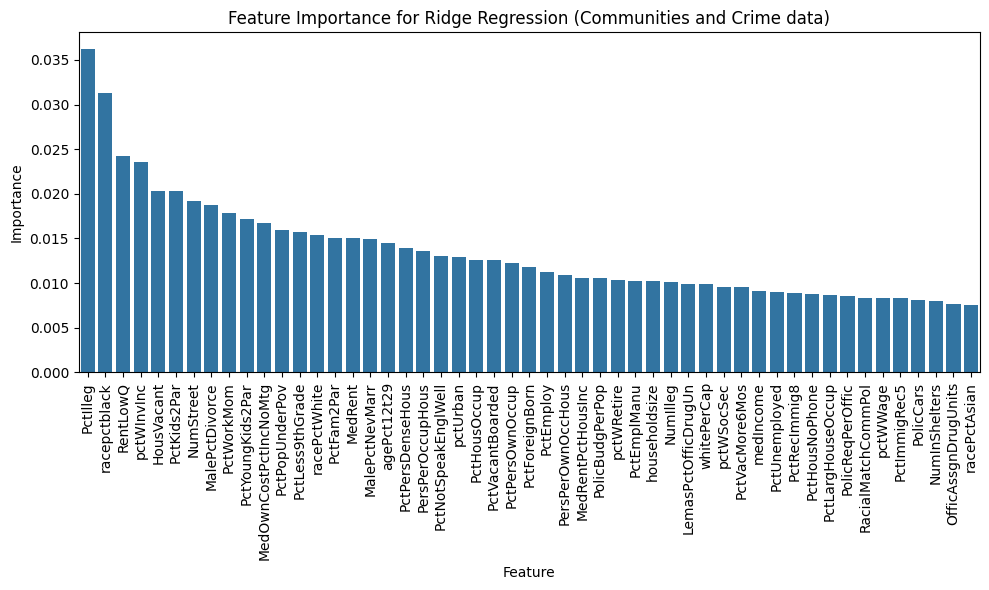

,Feature,Importance
0,PctIlleg,0.036286
1,racepctblack,0.031275
2,RentLowQ,0.024282
3,pctWInvInc,0.023626
4,HousVacant,0.020335
5,PctKids2Par,0.020326
6,NumStreet,0.019247
7,MalePctDivorce,0.018779
8,PctWorkMom,0.017853
9,PctYoungKids2Par,0.017143


In [9]:
# Get selected features using Ridge
ridge_selector = SelectFromModel(ridge_model, prefit=True)
ridge_feature_importance = pd.DataFrame(
    sorted(
        zip(
            communities_and_crime_X.columns[ridge_selector.get_support()],
            np.abs(ridge_model.coef_)[ridge_selector.get_support()],
        ),
        key=lambda x: x[1],
        reverse=True,
    ),
    columns=["Feature", "Importance"],
)

_, ax = plt.subplots(1, figsize=(10, 6))

# Plot a bar chart of feature importance for Ridge
sns.barplot(
    x="Feature",
    y="Importance",
    data=ridge_feature_importance,
    legend=False,
    ax=ax,
)
ax.set_title("Feature Importance for Ridge Regression (Communities and Crime data)")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
plt.xticks(rotation=90, axes=ax)
plt.tight_layout()
plt.show()

ridge_feature_importance

### Lasso Regression


In [10]:
# Find the best hyperparameters using cross-validation
lasso_cv = LassoCV(alphas=None, cv=5)
lasso_cv.fit(communities_and_crime_X_train, communities_and_crime_y_train)
best_alpha_lasso = lasso_cv.alpha_

# Train the model using the best hyperparameters
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(communities_and_crime_X_train, communities_and_crime_y_train)

# Make predictions and evaluate the model
y_pred_lasso = lasso_model.predict(communities_and_crime_X_test)
lasso_mae = mean_absolute_error(communities_and_crime_y_test, y_pred_lasso)
lasso_mse = mean_squared_error(communities_and_crime_y_test, y_pred_lasso)
lasso_r2 = r2_score(communities_and_crime_y_test, y_pred_lasso)

print(f"Lasso Regression (Communities and Crime data) - Best Alpha: {best_alpha_lasso}")
print(
    f"Lasso Regression (Communities and Crime data) - Mean Absolute Error: {lasso_mae}"
)
print(
    f"Lasso Regression (Communities and Crime data) - Mean Squared Error: {lasso_mse}"
)
print(f"Lasso Regression (Communities and Crime data) - R-squared: {lasso_r2}")

Lasso Regression (Communities and Crime data) - Best Alpha: 0.004641332486841567
Lasso Regression (Communities and Crime data) - Mean Absolute Error: 0.09111243867320325
Lasso Regression (Communities and Crime data) - Mean Squared Error: 0.017334245487144347
Lasso Regression (Communities and Crime data) - R-squared: 0.6380838255138094


/home/mokot/FRI/StrojnoUcenje/Assignment3/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


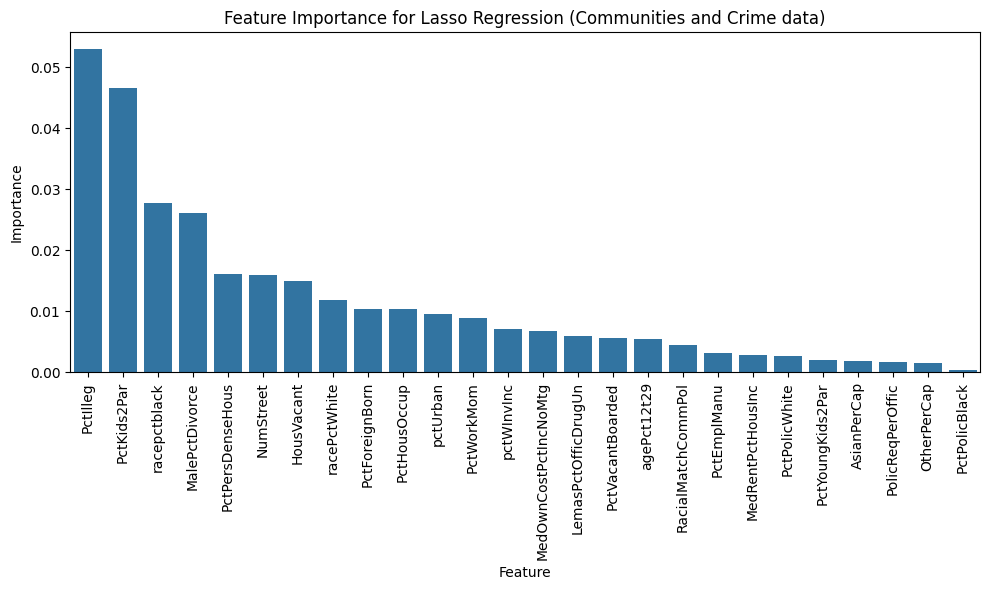

,Feature,Importance
0,PctIlleg,0.053085
1,PctKids2Par,0.046666
2,racepctblack,0.027778
3,MalePctDivorce,0.026116
4,PctPersDenseHous,0.016075
5,NumStreet,0.015916
6,HousVacant,0.014973
7,racePctWhite,0.011876
8,PctForeignBorn,0.010374
9,PctHousOccup,0.010372


In [11]:
# Get selected features using Lasso
lasso_selector = SelectFromModel(lasso_model, prefit=True)
lasso_feature_importance = pd.DataFrame(
    sorted(
        zip(
            communities_and_crime_X.columns[lasso_selector.get_support()],
            np.abs(lasso_model.coef_)[lasso_selector.get_support()],
        ),
        key=lambda x: x[1],
        reverse=True,
    ),
    columns=["Feature", "Importance"],
)

_, ax = plt.subplots(1, figsize=(10, 6))

# Plot a bar chart of feature importance for Lasso
sns.barplot(
    x="Feature",
    y="Importance",
    data=lasso_feature_importance,
    legend=False,
    ax=ax,
)
ax.set_title("Feature Importance for Lasso Regression (Communities and Crime data)")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
plt.xticks(rotation=90, axes=ax)
plt.tight_layout()
plt.show()

lasso_feature_importance

### Feature Comparison


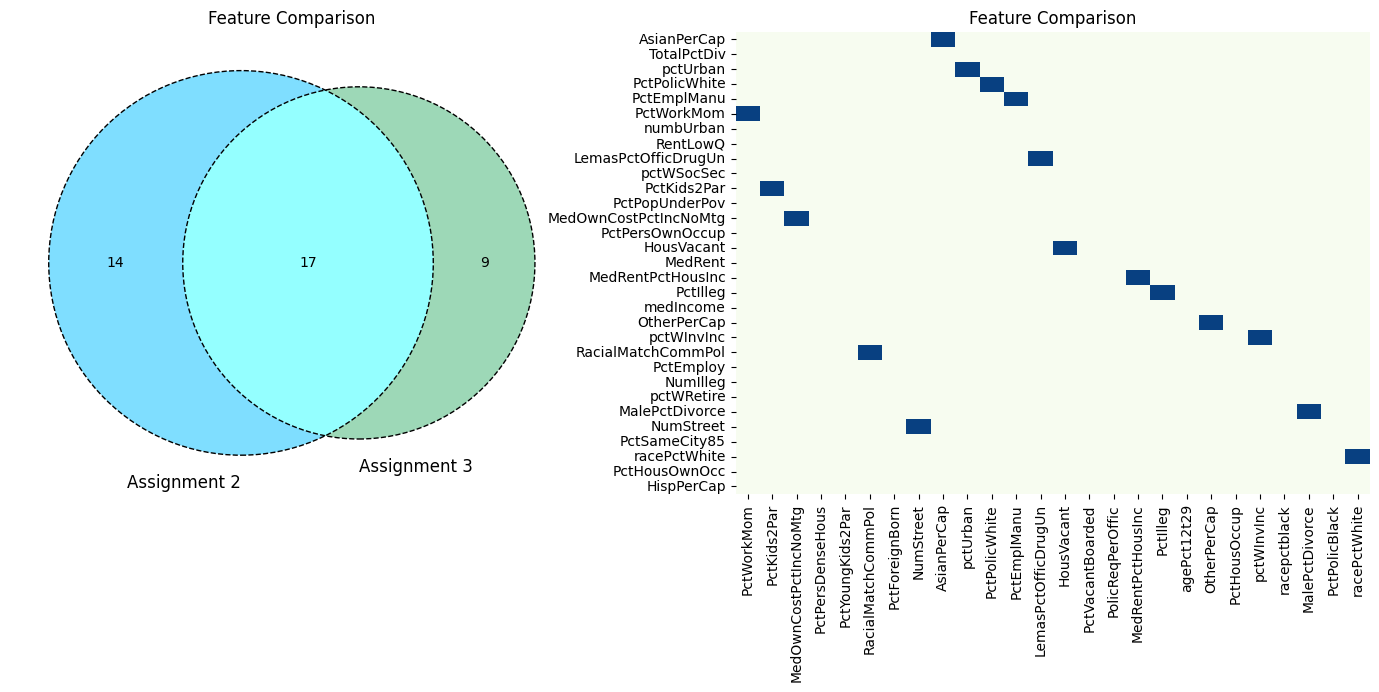

In [12]:
# List of features from previous assignment
features_assignment_2 = set(
    {
        "PctIlleg",
        "TotalPctDiv",
        "HousVacant",
        "racePctWhite",
        "PctWorkMom",
        "PctKids2Par",
        "pctUrban",
        "NumStreet",
        "numbUrban",
        "PctPolicWhite",
        "MalePctDivorce",
        "MedOwnCostPctIncNoMtg",
        "PctEmplManu",
        "PctSameCity85",
        "pctWRetire",
        "MedRentPctHousInc",
        "PctPopUnderPov",
        "pctWInvInc",
        "pctWSocSec",
        "LemasPctOfficDrugUn",
        "HispPerCap",
        "RacialMatchCommPol",
        "NumIlleg",
        "RentLowQ",
        "MedRent",
        "PctPersOwnOccup",
        "AsianPerCap",
        "PctHousOwnOcc",
        "medIncome",
        "OtherPerCap",
        "PctEmploy",
    }
)

# List of features from this assignment
features_assignment_3 = set(lasso_feature_importance["Feature"])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot a venn diagram of features from previous assignment and this assignment
venn2(
    [features_assignment_2, features_assignment_3],
    set_labels=("Assignment 2", "Assignment 3"),
    set_colors=("deepskyblue", "mediumseagreen"),
    alpha=0.5,
    ax=ax1,
)
venn2_circles(
    [features_assignment_2, features_assignment_3],
    linestyle="dashed",
    linewidth=1,
    color="black",
    ax=ax1,
)

ax1.set_title("Feature Comparison")


# Plot a heatmap of features from previous assignment and this assignment
feature_matrix = np.full(
    (len(features_assignment_2), len(features_assignment_3)), False, dtype=bool
)
for index_1, value_1 in enumerate(features_assignment_2):
    for index_2, value_2 in enumerate(features_assignment_3):
        if value_1 == value_2:
            feature_matrix[index_1, index_2] = True
sns.heatmap(
    feature_matrix,
    annot=False,
    yticklabels=features_assignment_2,
    xticklabels=features_assignment_3,
    cmap="GnBu",
    cbar=False,
    ax=ax2,
)
ax2.set_title("Feature Comparison")

plt.show()

### Gradient Descent and Stochastic Gradient Descent


In [13]:
class MyRidgeRegression:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        # Add a column of ones to X
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Calculate the coefficients
        A = np.dot(X.T, X) + self.alpha * np.eye(X.shape[1])
        b = np.dot(X.T, y)
        self.w = np.linalg.solve(A, b)

    def predict(self, X):
        # Add a column of ones to X
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        return np.dot(X, self.w)


def ridgeRegressionGradientDescent(X, y, alpha, learning_rate, num_iterations):
    m, n = X.shape

    # Initialize coefficients to zeros
    theta = np.random.randn(n)

    for _ in range(num_iterations):
        # Calculate the predictions
        predictions = np.dot(X, theta)

        # Compute the gradient of the cost function with regularization
        gradient = (1 / m) * np.dot(X.T, predictions - y)
        gradient[1:] = gradient[1:] + alpha * theta[1:]

        # Update theta using the learning rate
        theta = theta - learning_rate * gradient

        yield theta


def ridgeRegressionStochasticGradientDescent(
    X, y, alpha, learning_rate, num_iterations, batch_size
):
    m, n = X.shape

    # Initialize coefficients to zeros
    theta = np.random.randn(n)

    for _ in range(num_iterations):
        # Shuffle the data
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]

        for index in range(0, m, batch_size):
            # Randomly select a training example
            X_batch = X[index : index + batch_size]
            y_batch = y[index : index + batch_size]

            # Calculate the predictions
            predictions = np.dot(X_batch, theta)

            # Compute the gradient of the cost function with regularization
            gradient = (1 / batch_size) * np.dot(X_batch.T, predictions - y_batch)
            gradient[1:] = gradient[1:] + (1 / batch_size) * alpha * theta[1:]

            # Update theta using the learning rate
            theta = theta - learning_rate * gradient

        yield theta

In [14]:
# Split the data into training and testing sets (80% training, 20% testing)
wine_quality_X = wine_quality_data.iloc[:, :-1]
wine_quality_y = wine_quality_data.iloc[:, -1]

(
    wine_quality_X_train,
    wine_quality_X_test,
    wine_quality_y_train,
    wine_quality_y_test,
) = train_test_split(wine_quality_X, wine_quality_y, test_size=0.2, random_state=42)

# Standardize the communities and crime data
scaler = StandardScaler()
wine_quality_X_train = pd.DataFrame(
    scaler.fit_transform(wine_quality_X_train),
    columns=wine_quality_X_train.columns,
)
wine_quality_X_test = scaler.transform(wine_quality_X_test)

# Add a column of ones to X and convert y to numpy array
wine_quality_X_train = np.insert(wine_quality_X_train, 0, 1, axis=1)
wine_quality_X_test = np.insert(wine_quality_X_test, 0, 1, axis=1)
wine_quality_y_train = wine_quality_y_train.to_numpy()
wine_quality_y_test = wine_quality_y_test.to_numpy()

In [15]:
# Find the best hyperparameters using cross-validation
ridge_cv = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=5)
ridge_cv.fit(wine_quality_X_train, wine_quality_y_train)
alpha = ridge_cv.alpha_

# Define the parameters for gradient descent and stochastic gradient descent
gradient_descent_alpha = 0.1
gradient_descent_learning_rate = 0.01
gradient_descent_num_iterations = 1000
stochastic_gradient_descent_alpha = 0.1
stochastic_gradient_descent_learning_rate = 0.000001
stochastic_gradient_descent_num_iterations = 2500
stochastic_gradient_descent_batch_size = 1

time_start = time.time()

# Ridge regression from scikit-learn
ridge = Ridge(alpha=alpha)
ridge.fit(wine_quality_X_train, wine_quality_y_train)
scikit_learn_theta = ridge.coef_

time_stop = time.time()
scikit_learn_time = time_stop - time_start

# Ridge regression with gradient descent
gradient_descent_theta = ridgeRegressionGradientDescent(
    wine_quality_X_train,
    wine_quality_y_train,
    gradient_descent_alpha,
    gradient_descent_learning_rate,
    gradient_descent_num_iterations,
)

# Ridge regression with stochastic gradient descent
stochastic_gradient_descent_theta = ridgeRegressionStochasticGradientDescent(
    wine_quality_X_train,
    wine_quality_y_train,
    stochastic_gradient_descent_alpha,
    stochastic_gradient_descent_learning_rate,
    stochastic_gradient_descent_num_iterations,
    stochastic_gradient_descent_batch_size,
)

In [16]:
def cost(X, y, theta, alpha):
    m, _ = X.shape

    # Calculate the predictions
    predictions = np.dot(X, theta)

    # Compute the cost function with regularization
    cost = (1 / (2 * m)) * np.sum(np.square(predictions - y)) + alpha * np.sum(
        np.square(theta[1:])
    )

    # Compute the mean squared error
    cost = mean_squared_error(y, predictions)

    return cost

[]

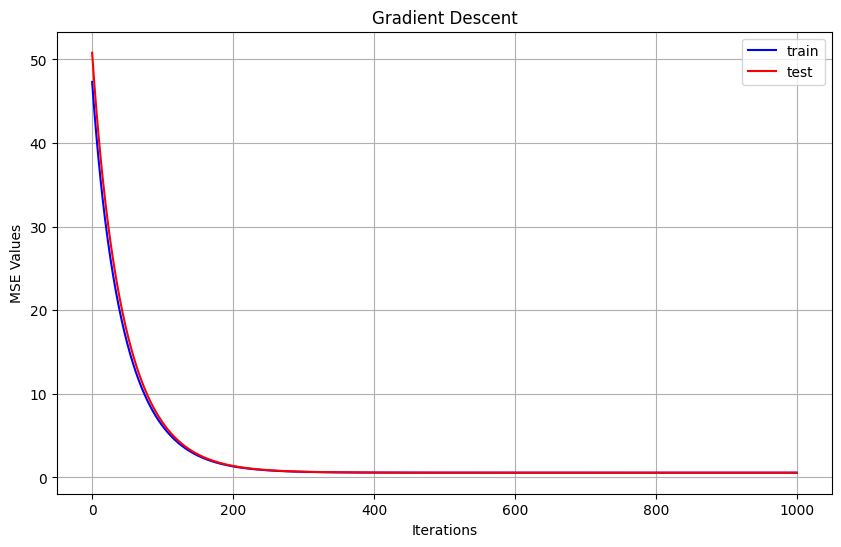

In [17]:
time_start = time.time()

# Initialize lists to store the mean squared error for each iteration
gradient_descent = []
gradient_descent_theta = list(gradient_descent_theta)

# Loop through each iteration and calculate the mean squared error
for theta in gradient_descent_theta:
    # Calculate the mean squared error for the training and testing sets
    train_mse_value = cost(
        wine_quality_X_train,
        wine_quality_y_train,
        theta,
        gradient_descent_alpha,
    )
    test_mse_value = cost(
        wine_quality_X_test,
        wine_quality_y_test,
        theta,
        gradient_descent_alpha,
    )

    # Append the mean squared error to the list
    gradient_descent.append(
        {"train": train_mse_value, "test": test_mse_value},
    )

time_stop = time.time()
gradient_descent_time = time_stop - time_start

# Convert the list to a pandas dataframe and plot the mean squared error
gradient_descent = pd.DataFrame(gradient_descent)
ax = gradient_descent.plot(figsize=(10, 6), colormap="bwr")
ax.set_title("Gradient Descent")
ax.set_xlabel("Iterations")
ax.set_ylabel("MSE Values")
ax.grid()
plt.plot()

[]

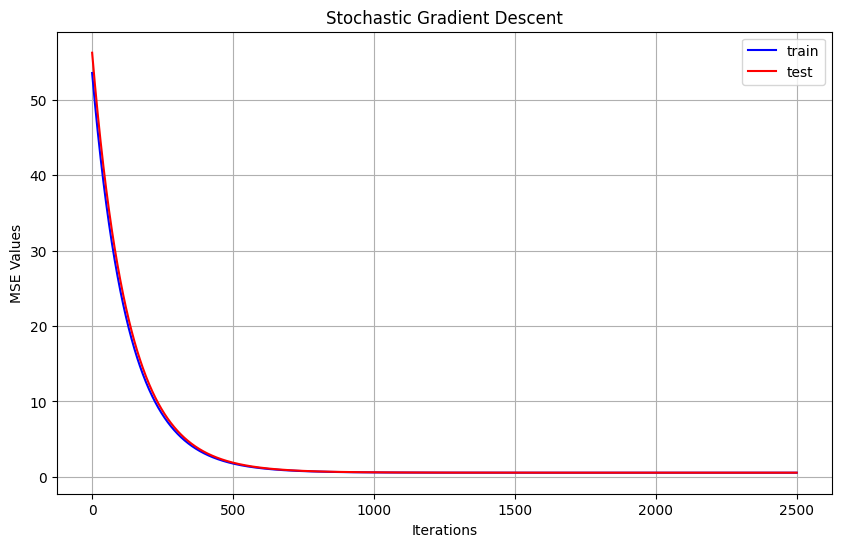

In [18]:
time_start = time.time()

# Initialize lists to store the mean squared error for each iteration
stochastic_gradient_descent = []
stochastic_gradient_descent_theta = list(stochastic_gradient_descent_theta)

for theta in stochastic_gradient_descent_theta:
    # Calculate the mean squared error for the training and testing sets
    train_mse_value = cost(
        wine_quality_X_train,
        wine_quality_y_train,
        theta,
        stochastic_gradient_descent_alpha,
    )
    test_mse_value = cost(
        wine_quality_X_test,
        wine_quality_y_test,
        theta,
        stochastic_gradient_descent_alpha,
    )

    # Append the mean squared error to the list
    stochastic_gradient_descent.append(
        {"train": train_mse_value, "test": test_mse_value},
    )

time_stop = time.time()
stochastic_gradient_descent_time = time_stop - time_start

# Convert the list to a pandas dataframe and plot the mean squared error
stochastic_gradient_descent = pd.DataFrame(stochastic_gradient_descent)
ax = stochastic_gradient_descent.plot(figsize=(10, 6), colormap="bwr")
ax.set_title("Stochastic Gradient Descent")
ax.set_xlabel("Iterations")
ax.set_ylabel("MSE Values")
ax.grid()
plt.plot()

In [19]:
# Print time results
print(f"Time taken by scikit-learn: {scikit_learn_time}")
print(f"Time taken by gradient descent: {gradient_descent_time}")
print(f"Time taken by stochastic gradient descent: {stochastic_gradient_descent_time}")

# Make predictions and evaluate the scikit-learn model
scikit_learn_predictions = np.dot(wine_quality_X_test, scikit_learn_theta)
ridge_mae = mean_absolute_error(wine_quality_y_test, scikit_learn_predictions)
ridge_mse = mean_squared_error(wine_quality_y_test, scikit_learn_predictions)
ridge_r2 = r2_score(wine_quality_y_test, scikit_learn_predictions)

print(f"scikit-learn - Mean Absolute Error: {ridge_mae}")
print(f"scikit-learn - Mean Squared Error: {ridge_mse}")
print(f"scikit-learn - R-squared: {ridge_r2}")


# Make predictions and evaluate the gradient descent model
gradient_descent_predictions = np.dot(
    wine_quality_X_test,
    gradient_descent_theta[-1],
)
ridge_mae = mean_absolute_error(wine_quality_y_test, gradient_descent_predictions)
ridge_mse = mean_squared_error(wine_quality_y_test, gradient_descent_predictions)
ridge_r2 = r2_score(wine_quality_y_test, gradient_descent_predictions)

print(f"Gradient Descent - Mean Absolute Error: {ridge_mae}")
print(f"Gradient Descent - Mean Squared Error: {ridge_mse}")
print(f"Gradient Descent - R-squared: {ridge_r2}")

# Make predictions and evaluate the stochastic gradient descent model
stochastic_gradient_descent_predictions = np.dot(
    wine_quality_X_test,
    stochastic_gradient_descent_theta[-1],
)
ridge_mae = mean_absolute_error(
    wine_quality_y_test, stochastic_gradient_descent_predictions
)
ridge_mse = mean_squared_error(
    wine_quality_y_test, stochastic_gradient_descent_predictions
)
ridge_r2 = r2_score(wine_quality_y_test, stochastic_gradient_descent_predictions)

print(f"Stochastic Gradient Descent - Mean Absolute Error: {ridge_mae}")
print(f"Stochastic Gradient Descent - Mean Squared Error: {ridge_mse}")
print(f"Stochastic Gradient Descent - R-squared: {ridge_r2}")

Time taken by scikit-learn: 0.001684427261352539
Time taken by gradient descent: 2.2364323139190674
Time taken by stochastic gradient descent: 100.94556546211243
scikit-learn - Mean Absolute Error: 5.8823372783775945
scikit-learn - Mean Squared Error: 35.171555452633946
scikit-learn - R-squared: -44.413525413562766
Gradient Descent - Mean Absolute Error: 0.5923053681879057
Gradient Descent - Mean Squared Error: 0.5768887245387238
Gradient Descent - R-squared: 0.2551210654325733
Stochastic Gradient Descent - Mean Absolute Error: 0.5891744145661935
Stochastic Gradient Descent - Mean Squared Error: 0.5722918139985901
Stochastic Gradient Descent - R-squared: 0.26105659802280445


### Conclusion

In this assignment we have trained the ridge and lasso regression models on the "Communities and Crime" dataset. Trying different regularization parameters we have found the optimal one. With the Ridge regression model we have achieved the following results:

```json
Best Regularization Parameter: 100.0
Mean Absolute Error: 0.39377311540996124
Mean Squared Error: 0.32446203471122254
R-squared: 0.6324599770090971
```

With the Lasso regression model we have achieved the following results:

```json
Best Regularization Parameter: 0.021558356343788422
Mean Absolute Error: 0.39142039995502365
Mean Squared Error: 0.31994457812701776
R-squared: 0.637577204663472
```

Comparing the results of the feature selection we have implemented in the previous assignment with the attributes lasso selected we have found that the results are similar. The attributes selected by the lasso regression model are:

```json
{
    "PctIlleg",
    "PctKids2Par",
    "racepctblack",
    "MalePctDivorce",
    "PctPersDenseHous",
    "NumStreet",
    "HousVacant",
    "racePctWhite",
    "PctHousOccup",
    "PctForeignBorn",
    "pctUrban",
    "PctWorkMom",
    "MedOwnCostPctIncNoMtg",
    "pctWInvInc",
    "LemasPctOfficDrugUn",
    "PctVacantBoarded",
    "agePct12t29",
    "RacialMatchCommPol",
    "PctEmplManu",
    "PctPolicWhite",
    "MedRentPctHousInc",
    "PolicReqPerOffic",
    "AsianPerCap",
    "PctYoungKids2Par",
    "OtherPerCap",
    "PctPolicBlack"
}
```

The attributes selected by the feature selection method are:

```json
{
    "PctIlleg",
    "TotalPctDiv",
    "HousVacant",
    "racePctWhite",
    "PctWorkMom",
    "PctKids2Par",
    "pctUrban",
    "NumStreet",
    "numbUrban",
    "PctPolicWhite",
    "MalePctDivorce",
    "MedOwnCostPctIncNoMtg",
    "PctEmplManu",
    "PctSameCity85",
    "pctWRetire",
    "MedRentPctHousInc",
    "PctPopUnderPov",
    "pctWInvInc",
    "pctWSocSec",
    "LemasPctOfficDrugUn",
    "HispPerCap",
    "RacialMatchCommPol",
    "NumIlleg",
    "RentLowQ",
    "MedRent",
    "PctPersOwnOccup",
    "AsianPerCap",
    "PctHousOwnOcc",
    "medIncome",
    "OtherPerCap",
    "PctEmploy",
}
```

We have also implemented the ridge regression model using gradient descent and stochastic gradient descent and tested it on the "Wine quality" dataset. We have tested different learning rates and found the optimal one for each method. The results of the two gradient descents comparing to the results of the ridge regression model are:

```json
# scikit-learn
Mean Absolute Error: 5.8823372783775945
Mean Squared Error: 35.171555452633946
R-squared: -44.413525413562766

# Gradient Descent
Mean Absolute Error: 0.593841104996695
Mean Squared Error: 0.5802279793462649
R-squared: 0.25080941838958537

# Stochastic Gradient Descent
Mean Absolute Error: 0.5913401454307751
Mean Squared Error: 0.5766618713204479
R-squared: 0.25541397839194446
```

We have used `alpha = 0.1` for the ridge regression model and `alpha = 0.01` for the gradient descent and stochastic gradient descent models. The optimal learning rate for the gradient descent model is `0.01` and for the stochastic gradient descent model is `0.000001`. The time to convergence for the gradient descent model is `2.74` seconds and for the stochastic gradient descent model is `86.61` seconds.
